# **Домашняя работа.**
## Тема: Ансамблирование.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, RidgeCV
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Выявляем не категориальные признаки

In [4]:
cat_feat_train = list(data.dtypes[(data.dtypes == object)].index)
data[cat_feat_train] = data[cat_feat_train].fillna('888888') #пропуски заменяем на 888888
cat_nunique = data[cat_feat_train].nunique()
cat_feat = list(cat_nunique[cat_nunique < 30].index)
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'SalePrice'])]

### Для категориальных признаков создаем dummy-переменные

In [5]:
dummy_train = pd.get_dummies(data[cat_feat], columns=cat_feat)
dummy_train_cols = list(set(dummy_train))
dummy_train = dummy_train[dummy_train_cols]
train = pd.concat([data[num_feat].fillna(888888), dummy_train], axis=1)

### Обучаем и делаем тесты

In [6]:
X = train.loc[:, train.columns]
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

### Кросс-валидация

In [7]:
def crossValidation(model, X, y, N = 10):
  kf = KFold(n_splits=N, shuffle=True)
  print(cross_val_score(model, X, y, cv=kf).mean())

# Строим случайный лес и выводим важность признаков

In [8]:
forest = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
forest.fit(X_train, y_train)
crossValidation(forest, X_train, y_train)

0.011433032616238724


In [9]:
imp = pd.Series(forest.feature_importances_)
imp.sort_values(ascending=False)

16     0.113696
0      0.062652
6      0.060884
27     0.054652
2      0.053340
         ...   
198    0.000000
199    0.000000
200    0.000000
201    0.000000
152    0.000000
Length: 305, dtype: float64

### Логистическая регрессия

In [10]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
crossValidation(log_reg, X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.006858662965533195


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### RidgeCV регрессия

In [11]:
ridge_cv = RidgeCV()
ridge_cv.fit(X_train, y_train)
crossValidation(ridge_cv, X_train, y_train)

0.766052949554543


### Стеккинг

In [12]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    auc_val = 1 - mean_squared_error(y, y_pred, squared=False)/ np.mean(y)
    print('Процент точности предсказания по средней квадратичной ошибке в моделе {0:} : {1:.4f}'.format(plot_label,auc_val))


def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

In [13]:
stack_cv = StratifiedKFold(n_splits=10, random_state=500)

meta_train = []
meta_test = []
col_names = []

meta_tr, meta_te = get_meta_features(log_reg, X_train, y_train, X_test, stack_cv)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('log_reg')

meta_tr, meta_te = get_meta_features(ridge_cv, X_train, y_train, X_test, stack_cv)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('ridge_cv')

meta_tr, meta_te = get_meta_features(forest, X_train, y_train, X_test, stack_cv)
meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('random_forest')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTI

### Посмотрим на стэк

In [14]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

log_reg_meta = RandomForestRegressor()
log_reg_meta.fit(X_meta_train, y_train)
y_pred_meta_test = log_reg_meta.predict(X_meta_test)

show_auc(y_test, y_pred_meta_test, 'stack')

Процент точности предсказания по средней квадратичной ошибке в моделе stack : 0.8153


In [15]:
y_pred = ridge_cv.predict(X_test)
show_auc(y_test, y_pred, 'RidgeCV')

Процент точности предсказания по средней квадратичной ошибке в моделе RidgeCV : 0.8123


In [16]:
y_pred = log_reg.predict(X_test)
show_auc(y_test, y_pred, 'Logistic regression')

Процент точности предсказания по средней квадратичной ошибке в моделе Logistic regression : 0.4283


In [17]:
y_pred = forest.predict(X_test)
show_auc(y_test, y_pred, 'Random Forest')

Процент точности предсказания по средней квадратичной ошибке в моделе Random Forest : 0.6460


Лучше всего справляется RidgeCV

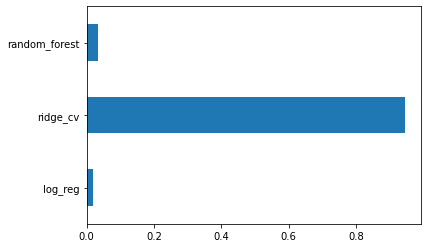

In [18]:
pd.Series(log_reg_meta.feature_importances_.flatten(), index=X_meta_train.columns).plot(kind='barh')